# Sparkify Churn Prediction

## 1. Load and clean dataset
Loading and cleaning the dataset, checking for invalid or missing data - for example, records without user IDs or session IDs.

In [1]:
# Import libraries

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, from_unixtime, substring, instr, encode, decode, split, month, desc, sum as Fsum
from pyspark.sql.types import LongType, IntegerType, StringType

import pandas as pd

from user_agents import parse

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import ticker
from build_axes import Hist, Barh, BarhStacked2
plt.style.use('ggplot')

# Configure pandas output display settings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
# Correct autocomplete not working

%config Completer.use_jedi = False

In [3]:
# Create spark session

spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [4]:
# Show link to spark UI at localhost:4040

spark

In [5]:
# Read sparkify dataset

filepath = 'mini_sparkify_event_data.json'
users_log = spark.read.json(filepath)

# Full dataset (12 Gb, 20 million rows)
# event_data = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'

# Mini dataset (128 Mb, 200 thousand rows, 1% of the full dataset)
# event_data = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'

In [6]:
print('users_log shape:', (users_log.count(), len(users_log.columns)))

users_log shape: (286500, 18)


In [7]:
users_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Adjust the data types

users_log = users_log.withColumn('registration', from_unixtime(col('registration') / 1000))
users_log = users_log.withColumn('ts', from_unixtime(col('ts') / 1000))
users_log = users_log.withColumn('userId', col('userId').cast(LongType()))

In [9]:
# Show example of string with wrong encoding

record = '''userId == 30
            and sessionId == 29
            and itemInSession == 68'''

encoding_example = users_log.where(record).collect()[0][0]

print('String should be:\t Björk')
print('String currently is:\t {}'.format(encoding_example))

String should be:	 Björk
String currently is:	 BjÃÂ¶rk


In [10]:
def encode_decode_column(df, column, encoding, decoding):
    """Encode a column from a dataframe and then decode it.
    
    Parameters:
        df (Spark dataframe): The dataframe that contains the column.
        column (String): The name of the column, from the df, to perform the encode and decode.
        encoding (string): The charset of the encoding (one of 'US-ASCII', 'ISO-8859-1', 'UTF-8', 'UTF-16BE', 'UTF-16LE', 'UTF-16').
        decoding (string): The charset of the decoding (one of 'US-ASCII', 'ISO-8859-1', 'UTF-8', 'UTF-16BE', 'UTF-16LE', 'UTF-16').
    
    Returns:
        df (Spark dataframe):
        
    Example:
        df = encode_decode_column(df, 'column_name', 'ISO-8859-1', 'UTF-8')
    """
    
    df = df.withColumn(column, encode(column, encoding))
    df = df.withColumn(column, decode(column, decoding))
    
    return df

In [11]:
date_columns = ['registration', 'ts']
categorical_columns = list(filter(lambda c: c[1] == 'string', users_log.dtypes))
categorical_columns = [c[0] for c in categorical_columns if c[0] not in date_columns]

In [12]:
# Fix the wrong encoding for the columns that are strings,
# and in order to retrieve the correct characters the encode-decode process must be done twice.

for column in categorical_columns:
    users_log = encode_decode_column(users_log, column, 'ISO-8859-1', 'UTF-8')
    users_log = encode_decode_column(users_log, column, 'ISO-8859-1', 'UTF-8')

In [13]:
# Test if the previous example is correct now

encoding_example_fixed = users_log.where(record).collect()[0][0]

print('String should be:\t Björk')
print('String currently is:\t {}'.format(encoding_example_fixed))

String should be:	 Björk
String currently is:	 Björk


In [14]:
users_log.limit(5).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 19:22:42,29,Rockpools,200,2018-09-30 21:01:57,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 15:20:30,8,Canada,200,2018-09-30 21:03:00,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 19:22:42,29,Time For Miracles,200,2018-09-30 21:06:34,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 15:20:30,8,Knocking On Forbidden Doors,200,2018-09-30 21:06:56,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 19:22:42,29,Harder Better Faster Stronger,200,2018-09-30 21:11:16,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


In [15]:
numerical_columns = list(filter(lambda c: c[1] == 'bigint' or c[1] == 'double', users_log.dtypes))
numerical_columns = list(item[0] for item in numerical_columns)

In [16]:
summary = users_log.select(numerical_columns).describe().toPandas().set_index('summary')
summary.index.name = None
summary

,itemInSession,length,sessionId,status,userId
count,286500,228108,286500,286500,278154
mean,114.41421291448516,249.11718197783722,1041.526554973822,210.05459685863875,59682.02278593872
stddev,129.76726201141085,99.23517921058324,726.7762634630834,31.50507848842202,109091.94999910519
min,0,0.78322,1,200,2
max,1321,3024.66567,2474,404,300025


In [17]:
# ADD BACK THE FUNCTION TO SHOW THE PERIOD OF THE DATE FIELDS

# Earliest registration: 2018-03-18 10:44:35
# Latest registration: 2018-11-26 13:49:14
# Earliest ts: 2018-09-30 21:01:57
# Latest ts: 2018-12-02 23:11:16

In [18]:
users_log_valid = users_log.dropna(how='any', subset=['userId', 'sessionId'])

old_rows, old_columns = users_log.count(), users_log.columns
new_rows, new_columns = users_log_valid.count(), users_log_valid.columns

print('users_log shape:\t', (old_rows, len(old_columns)))
print('users_log_valid shape:\t', (new_rows, len(new_columns)))
print('{} rows with empty user and session IDs removed'.format(old_rows - new_rows))

users_log shape:	 (286500, 18)
users_log_valid shape:	 (278154, 18)
8346 rows with empty user and session IDs removed


In [19]:
distinct_user_ids = users_log_valid.dropDuplicates(['userId']).count()
print('Distinct user IDs:', distinct_user_ids)

Distinct user IDs: 225


## 2. Exploratory Data Analysis

### 2.1. Visualizing the entire log

#### 2.1.1. Numerical features

In [20]:
n1 = users_log_valid.select('userId').toPandas()
n2 = users_log_valid.select('sessionId').toPandas()
n3 = users_log_valid.select('itemInSession').toPandas()
n4 = users_log_valid.select('length').toPandas()

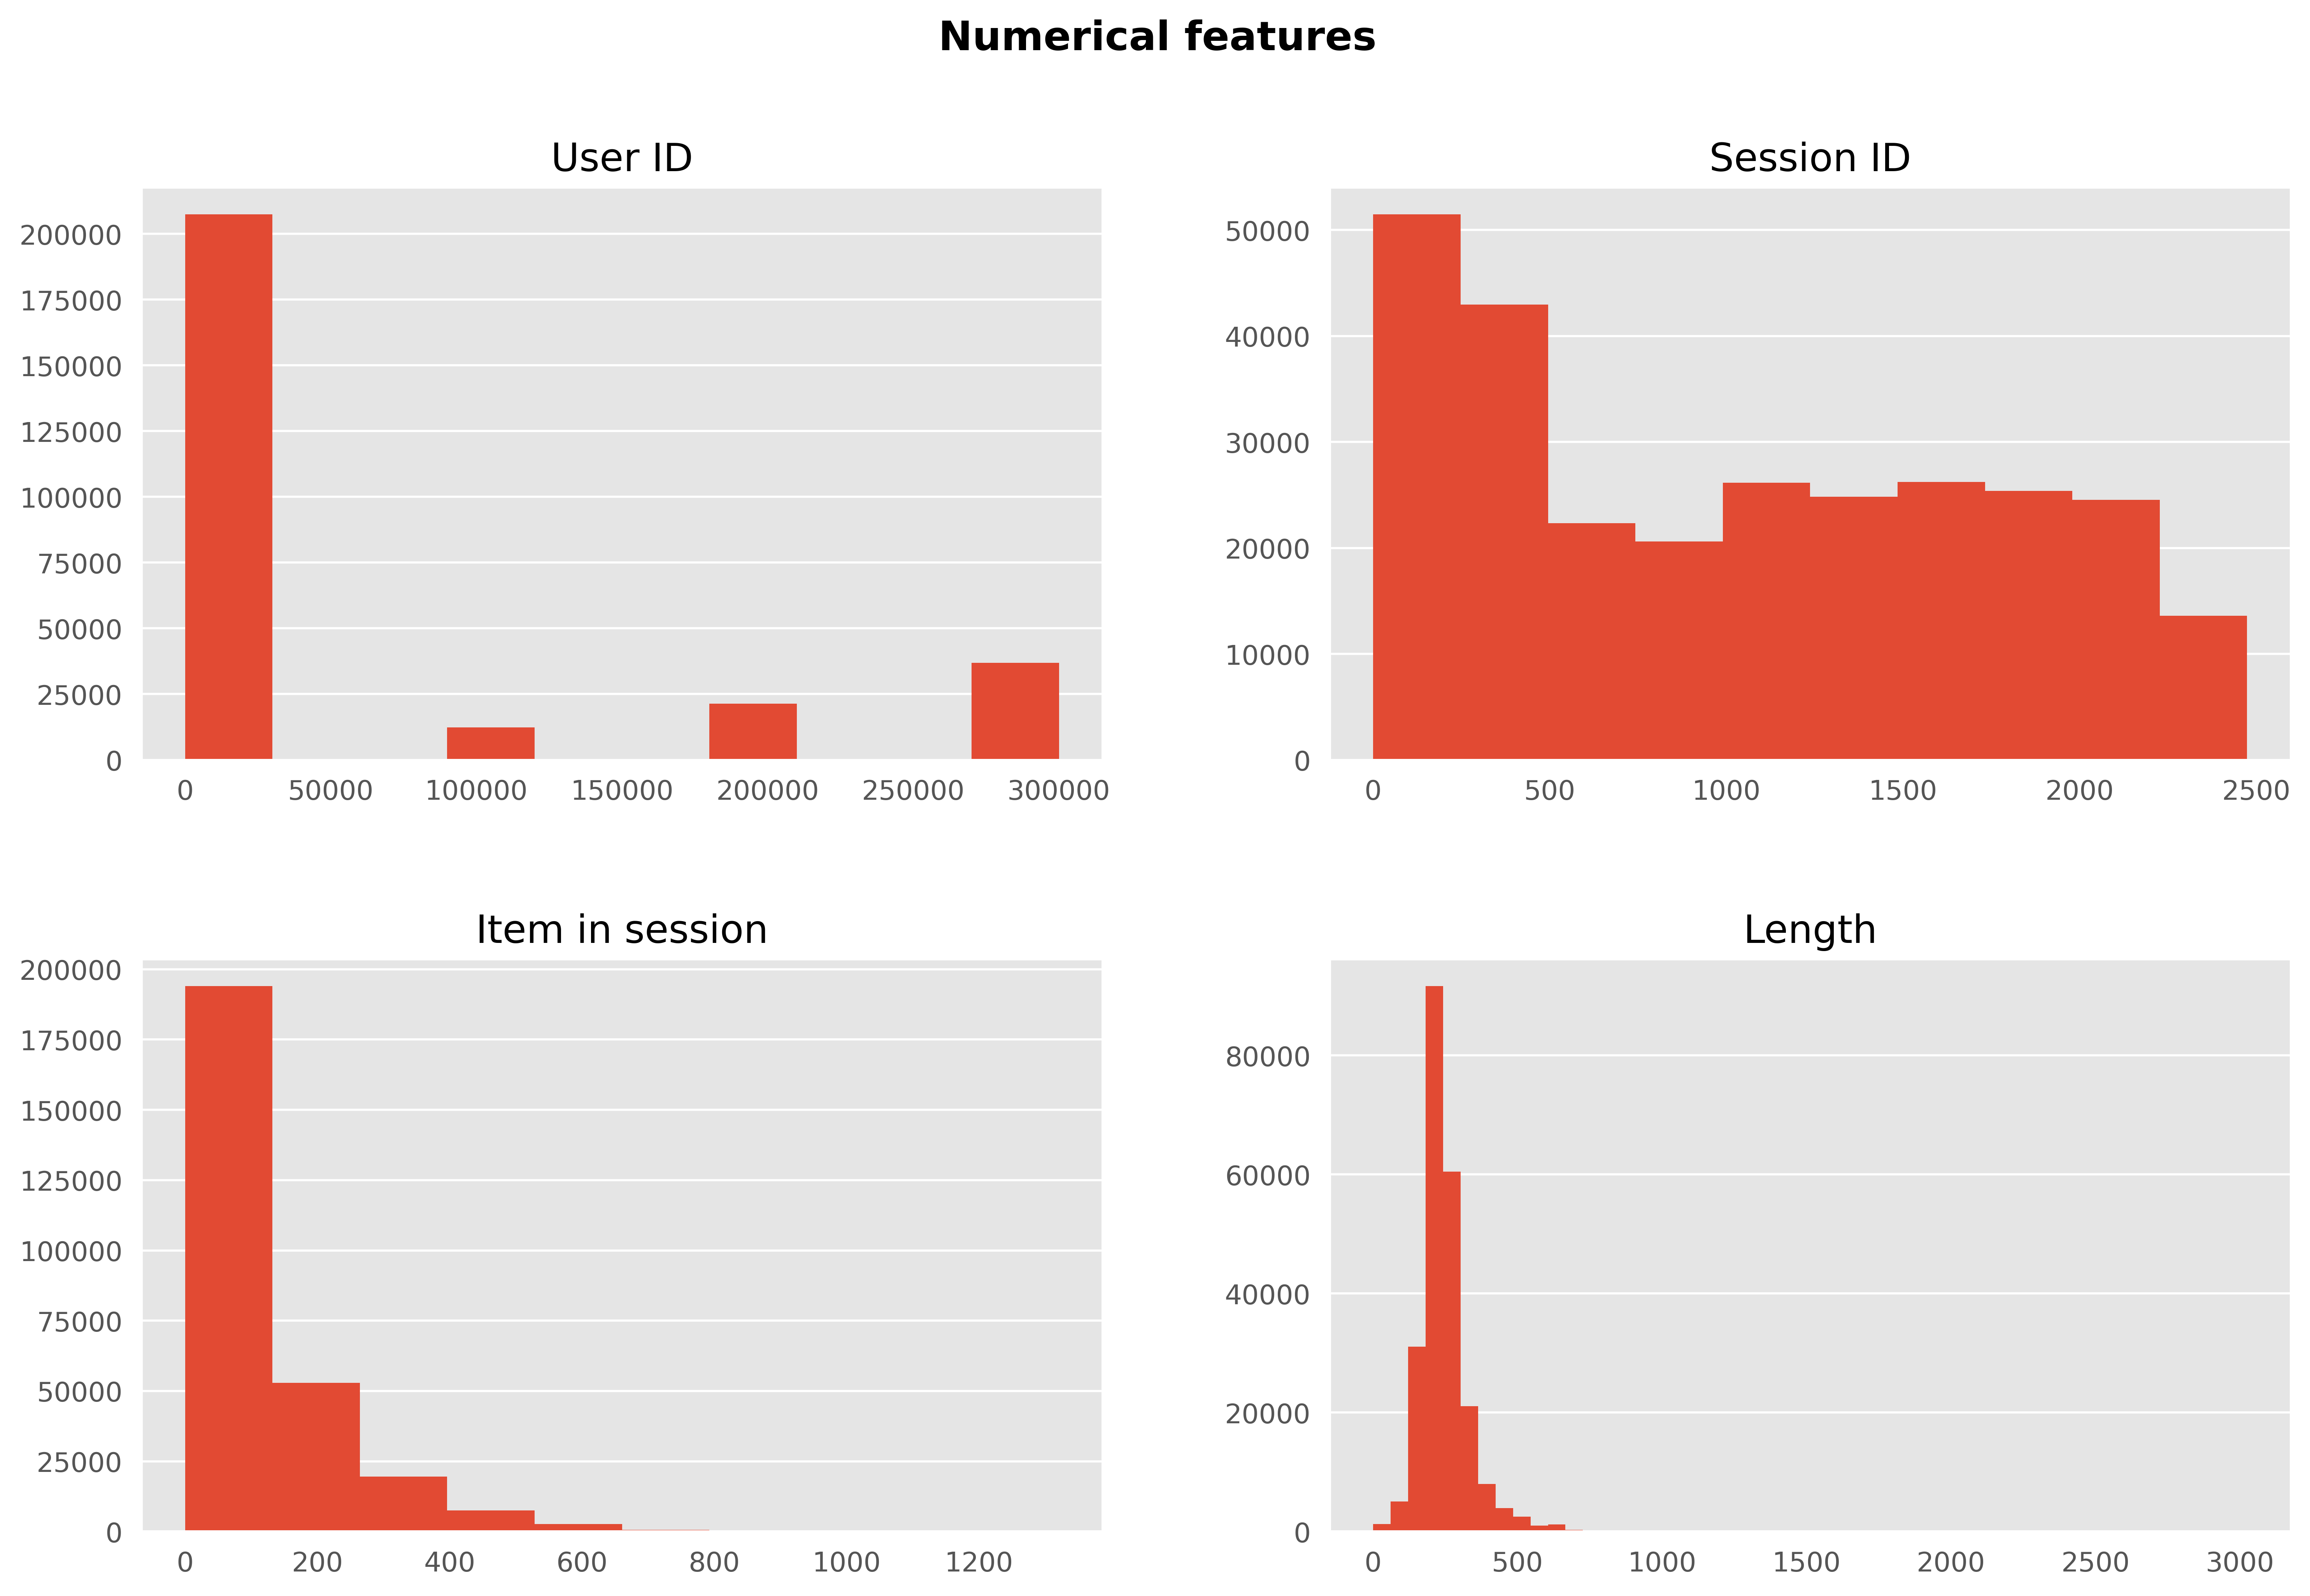

In [21]:
fig = plt.figure(figsize=(12, 8), dpi=500)
grid = gs.GridSpec(nrows=2, ncols=2)

fig.text(0.5, 1, 'Numerical features', ha='center', size=15, weight='bold')

Hist(n1, title='User ID').subplot(grid, 0, 0)
Hist(n2, title='Session ID').subplot(grid, 0, 1)
Hist(n3, title='Item in session').subplot(grid, 1, 0)
Hist(n4, title='Length', bins=50).subplot(grid, 1, 1)
    
plt.tight_layout(h_pad=4, w_pad=4, rect=(0, 0, 1, 0.96))
plt.show();

#### 2.1.2. Categorical features

In [22]:
def group_by_count_column(df, column, n_labels=20, n_label_chars=20):
    """Perform a group by and count the values from a desired column.
    
    Parameters:
        df (Spark dataframe): The dataframe that contains the column.
        column (String): The name of the column, from the df, to perform the group by and count its values.
    
    Returns:
        x:
        y:
    """
    
    group_by_count = df.select(column).groupby(column).count().toPandas().sort_values(by='count')
    
    x = group_by_count[column][-n_labels:]
    x = x.apply(lambda s: 'None' if s is None else s)
    x = x.apply(lambda s: s[:n_label_chars] + '...' if len(s) >= n_label_chars else s)
    
    y = group_by_count['count'][-n_labels:]
    
    return x, y

In [23]:
x_series, y_series = [], []
categorical_columns.remove('userAgent')  # User agent will be parsed and plotted latter

for column in categorical_columns:
    x, y = group_by_count_column(users_log_valid, column)
    x_series.append(x)
    y_series.append(y)

In [24]:
c1x, c2x, c3x, c4x, c5x, c6x, c7x, c8x, c9x, c10x = x_series
c1y, c2y, c3y, c4y, c5y, c6y, c7y, c8y, c9y, c10y = y_series

In [25]:
fig = plt.figure(figsize=(12, 24), dpi=500)
grid = gs.GridSpec(nrows=5, ncols=2)

fig.text(0.5, 1, 'Categorical features (top 20 classes)', ha='center', size=15, weight='bold')

Barh(c1x, c1y, title='Artist').subplot(grid, 0, 0)
Barh(c2x, c2y, title='Auth').subplot(grid, 0, 1)
Barh(c3x, c3y, title='First name').subplot(grid, 1, 0)
Barh(c4x, c4y, title='Gender', nbins=6).subplot(grid, 1, 1)
Barh(c5x, c5y, title='Last name').subplot(grid, 2, 0)
Barh(c6x, c6y, title='Level').subplot(grid, 2, 1)
Barh(c7x, c7y, title='Location').subplot(grid, 3, 0)
Barh(c8x, c8y, title='Method').subplot(grid, 3, 1)
Barh(c9x, c9y, title='Page').subplot(grid, 4, 0)
Barh(c10x, c10y, title='Song').subplot(grid, 4, 1)
    
plt.tight_layout(h_pad=3, w_pad=2, rect=(0, 0, 1, 0.985))
plt.show();

### 2.2. Defining churn
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [26]:
# Flag the churn

flag_cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
users_log_valid = users_log_valid.withColumn('churn', flag_cancellation_event('page'))

In [27]:
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
users_log_valid = users_log_valid.withColumn('churned', Fsum('churn').over(windowval))

### 2.3. Extracting new features

In [28]:
# Add the cohort

users_log_valid = users_log_valid.withColumn('cohort', substring('registration', 1, 7))

In [29]:
# Split the location between state and city

users_log_valid = users_log_valid.withColumn('city', split('location', ',')[0])
users_log_valid = users_log_valid.withColumn('state', split('location', ',')[1])
users_log_valid = users_log_valid.drop('location')

### 2.4. Parsing user agent

In [30]:
users_log_valid.select('userAgent').dropDuplicates(['userAgent']).limit(5).toPandas().head()

,userAgent
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"""
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"""
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"""
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"""


In [31]:
# Parse the user agent into: browser, os, device, isPhone, isTablet and isComputer

get_browser     = udf(lambda x: parse(x).browser.family, StringType())
get_os          = udf(lambda x: parse(x).os.family, StringType())
get_device      = udf(lambda x: parse(x).device.family, StringType())
get_is_phone    = udf(lambda x: 1 if parse(x).is_mobile else 0, IntegerType())
get_is_tablet   = udf(lambda x: 1 if parse(x).is_tablet else 0, IntegerType())
get_is_computer = udf(lambda x: 1 if parse(x).is_pc else 0, IntegerType())

In [32]:
users_log_valid = users_log_valid.withColumn('browser', get_browser('userAgent'))
users_log_valid = users_log_valid.withColumn('os', get_os('userAgent'))
users_log_valid = users_log_valid.withColumn('device', get_device('userAgent'))
users_log_valid = users_log_valid.withColumn('isPhone', get_is_phone('userAgent'))
users_log_valid = users_log_valid.withColumn('isTablet', get_is_tablet('userAgent'))
users_log_valid = users_log_valid.withColumn('isComputer', get_is_computer('userAgent'))

In [33]:
users_log_valid \
    .select('userAgent', 'browser', 'os', 'device', 'isPhone', 'isTablet', 'isComputer') \
    .dropDuplicates(['userAgent']) \
    .limit(5) \
    .toPandas() \
    .head()

,userAgent,browser,os,device,isPhone,isTablet,isComputer
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",Chrome,Mac OS X,Mac,0,0,1
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",Chrome,Windows,Other,0,0,1
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0,Firefox,Ubuntu,Other,0,0,1
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",Chrome,Mac OS X,Mac,0,0,1
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36""",Chrome,Mac OS X,Mac,0,0,1


### 2.5. Understanting relationships

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [149]:
level = users_log_valid \
    .select('userId', 'churned', 'level') \
    .dropDuplicates(['userId']) \
    .groupBy('churned', 'level') \
    .count() \
    .orderBy('churned', 'level')

In [150]:
level.show()

+-------+-----+-----+
|churned|level|count|
+-------+-----+-----+
|      0| free|   59|
|      0| paid|  114|
|      1| free|   21|
|      1| paid|   31|
+-------+-----+-----+



In [102]:
x0 = level.select('level').where('churned == 0').toPandas()['level']
y0 = level.select('count').where('churned == 0').toPandas()['count']

x1 = level.select('level').where('churned == 1').toPandas()['level']
y1 = level.select('count').where('churned == 1').toPandas()['count']

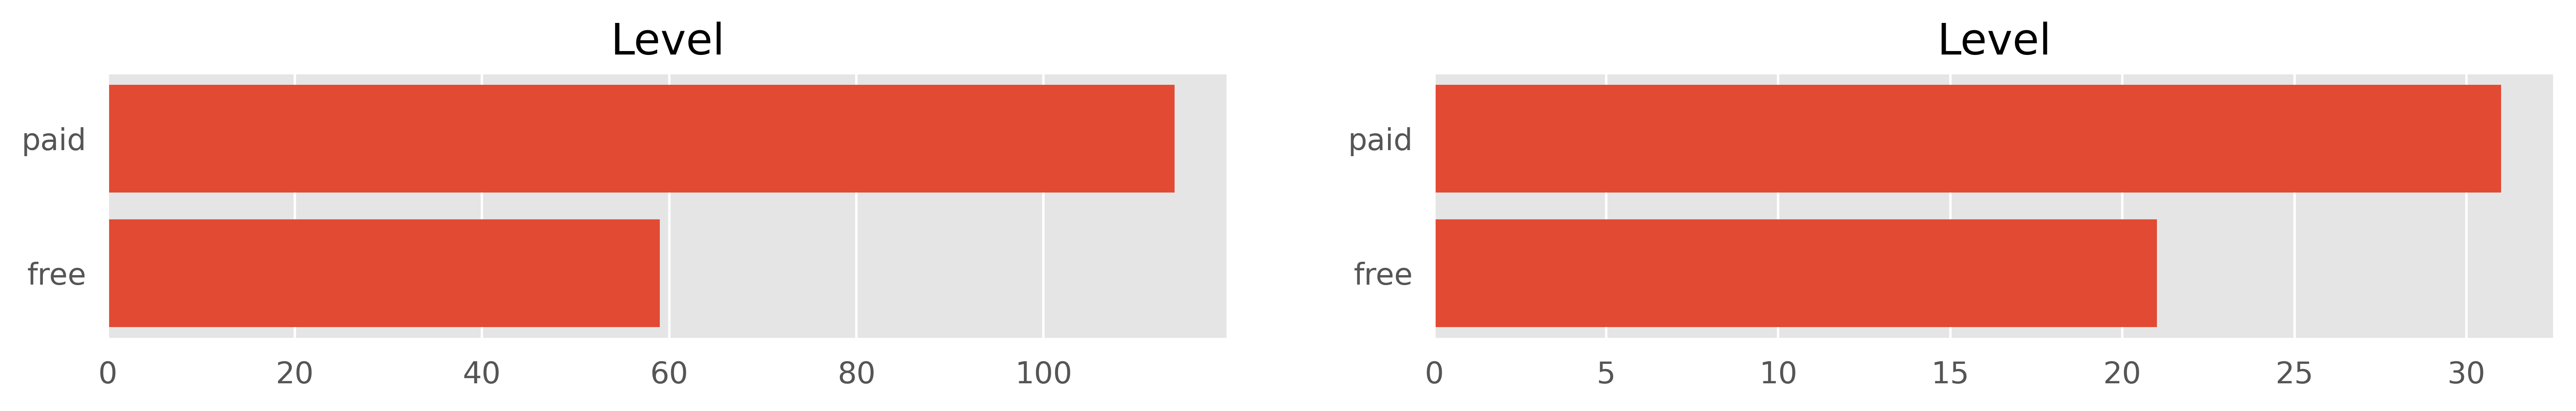

In [103]:
fig = plt.figure(figsize=(12, 2), dpi=500)
grid = gs.GridSpec(nrows=1, ncols=2)

Barh(x0, y0, title='Level').subplot(grid, 0, 0)
Barh(x1, y1, title='Level').subplot(grid, 0, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [105]:
level.show()

+-------+-----+-----+
|churned|level|count|
+-------+-----+-----+
|      0| free|   59|
|      0| paid|  114|
|      1| free|   21|
|      1| paid|   31|
+-------+-----+-----+



In [147]:
x = level.select('level').toPandas()['level']
y = level.select('count').toPandas()['count']

In [ ]:
fig = plt.figure(figsize=(12, 4), dpi=500)
grid = gs.GridSpec(nrows=1, ncols=2)

Bar(x, y, title='Level').subplot(grid, 0, 0)
Bar(x, y, title='Level').subplot(grid, 0, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [148]:
x

0    free
1    free
2    paid
3    paid
Name: level, dtype: object

In [170]:
def autolabel(rects, label, color):
    """Attach a text label above each bar in *rects*, displaying its height.
    
    Parameters:
        rects:
        label:
    
    Returns:
        ?
    """
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(label),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 6),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    color=color)
        break

In [155]:
everything = level.select('count').toPandas()['count'].tolist()

In [178]:
summ = level.select('count').where('level == "free"').toPandas()['count']
summ

0    59
1    21
Name: count, dtype: int64

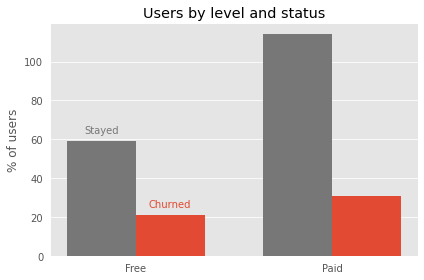

In [180]:
import numpy as np

labels = ['Free', 'Paid']
stayed = everything[:len(everything)//2]
churned = everything[len(everything)//2:]

xticks = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(xticks - width/2, stayed, width, label='Stayed', color='#777777')
rects2 = ax.bar(xticks + width/2, churned, width, label='Churned', color='#E24A33')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of users')
ax.set_title('Users by level and status')
ax.set_xticks(xticks)
ax.set_xticklabels(labels)
ax.tick_params(left=False, bottom=False)
ax.grid(axis='x')

autolabel(rects1, 'Stayed', '#777777')
autolabel(rects2, 'Churned', '#E24A33')

fig.tight_layout()
plt.show()

In [181]:
free_test = [59, 21]
paid_test = [114, 31]

free_sum = 80
paid_sum = 145

free_test_p = [59/free_sum, 21/free_sum]
paid_test_p = [114/paid_sum, 31/paid_sum]

In [182]:
free_test_p

[0.7375, 0.2625]

In [183]:
paid_test_p

[0.7862068965517242, 0.21379310344827587]

In [36]:
churn_test = [21.379310344827587, 26.25]
stayed_test = [78.62068965517242, 73.75]

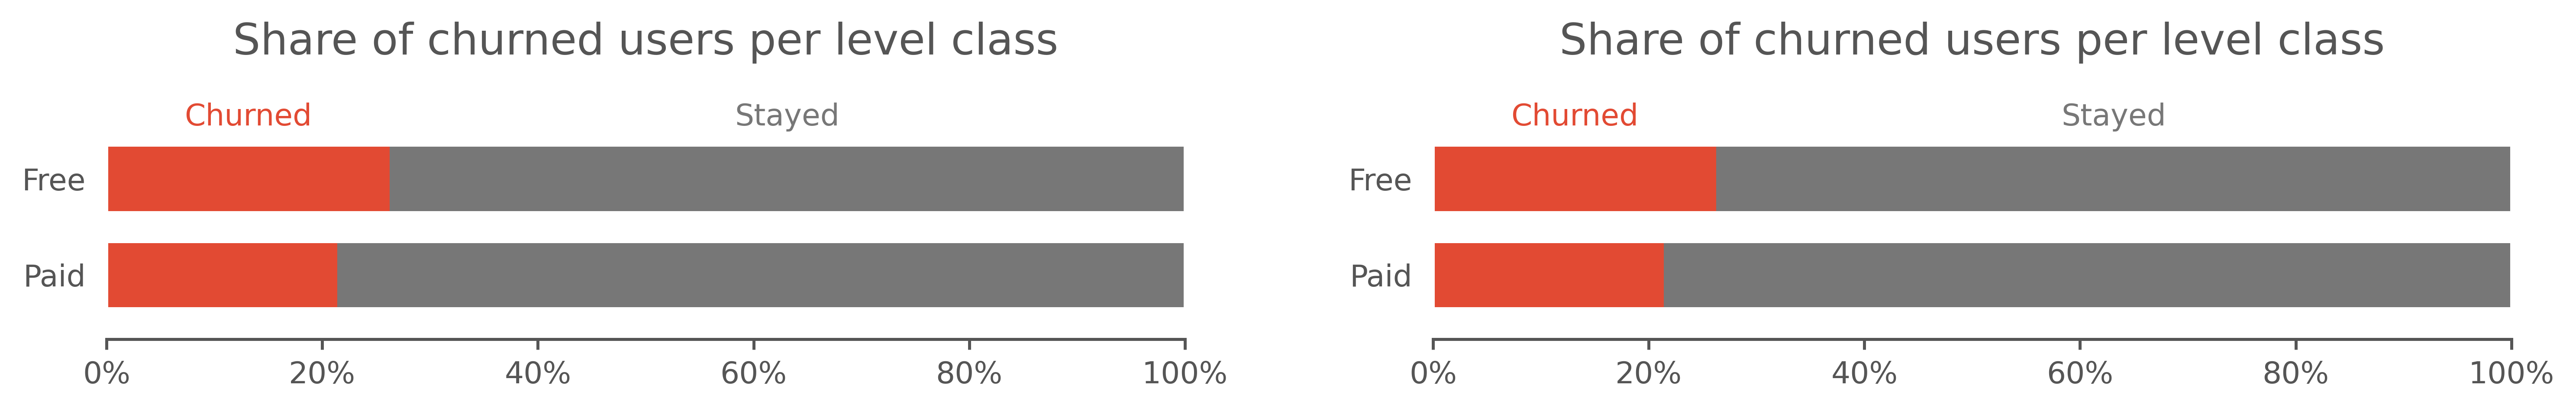

In [37]:
fig = plt.figure(figsize=(12, 2), dpi=500)
grid = gs.GridSpec(nrows=1, ncols=2)

labels = ['Paid', 'Free']
legend = ['Churned', 'Stayed']

BarhStacked2(churn_test, stayed_test, labels, 'Share of churned users per level class', legend).subplot(grid, 0, 0)
BarhStacked2(churn_test, stayed_test, labels, 'Share of churned users per level class', legend).subplot(grid, 0, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

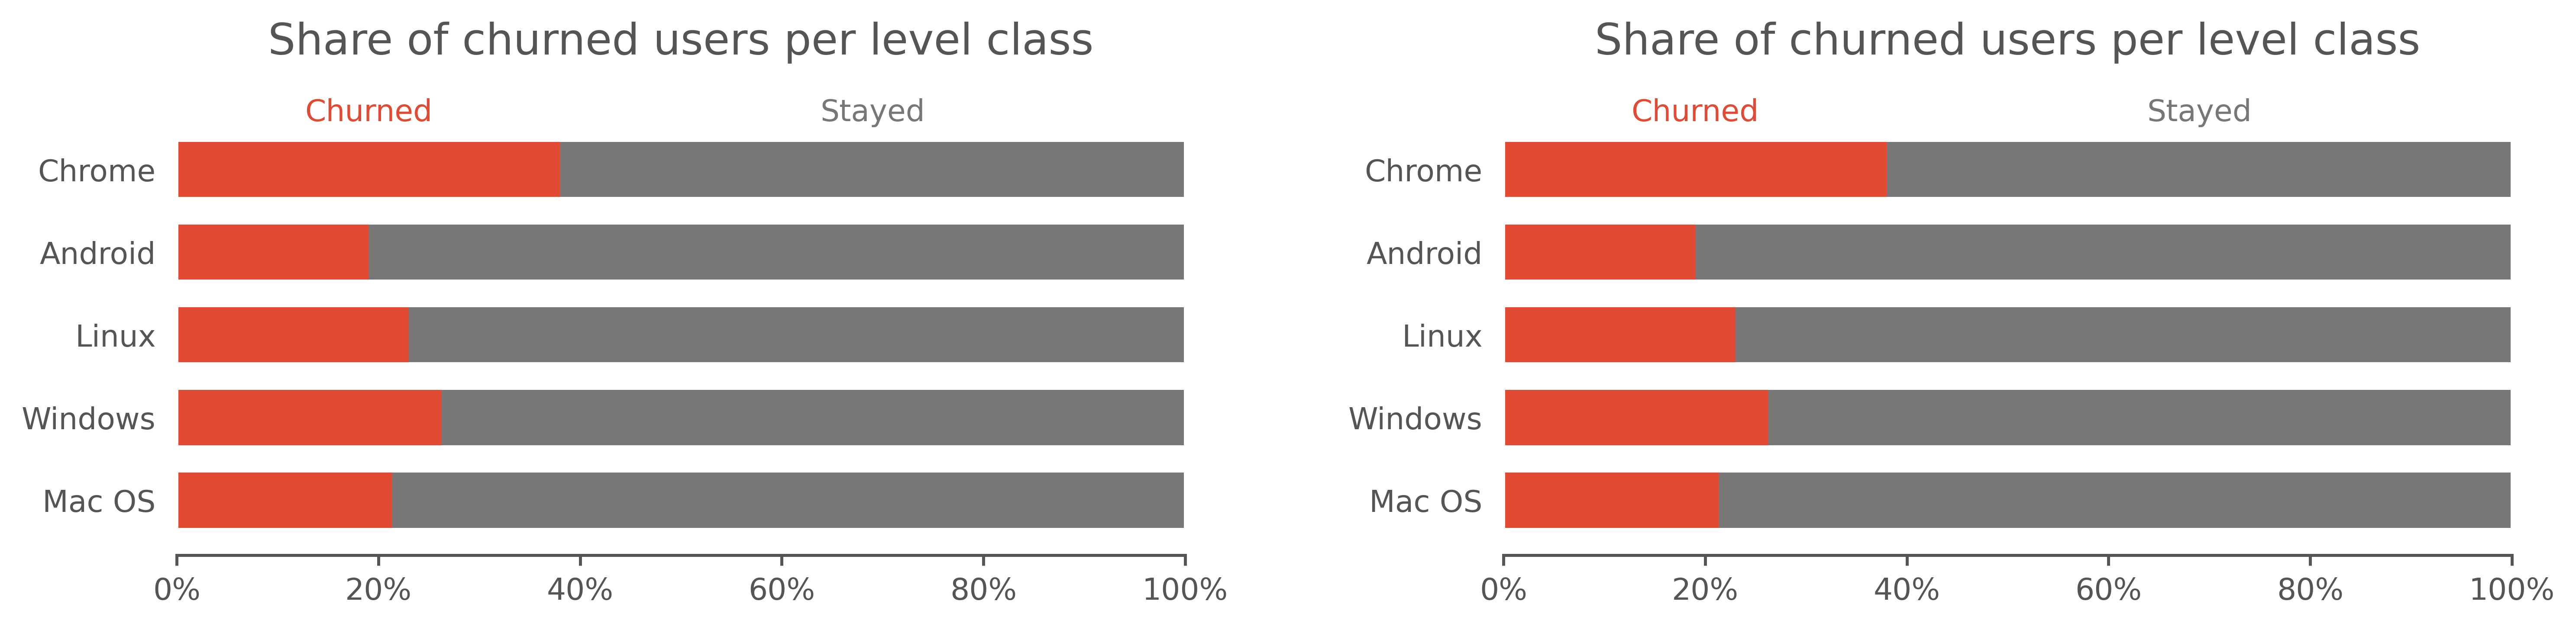

In [58]:
churn_test_5 = [21.379310344827587, 26.25, 23, 19, 38]
stayed_test_5 = [78.62068965517242, 73.75, 77, 81, 62]

fig = plt.figure(figsize=(12, 3), dpi=500)
grid = gs.GridSpec(nrows=1, ncols=2)

# x=1/16
index_5 = [1/16*2, 1/16*5, 1/16*8, 1/16*11, 1/16*14]  # [2x, 5x, 8x, 11x, 14x]
height_5 = 1/16*2  # [2x]
tick_label_5 = ['Mac OS', 'Windows', 'Linux', 'Android', 'Chrome']

ax = plt.subplot(grid[0, 0])
rects1 = ax.barh(index_5, churn_test_5, height=height_5, tick_label=tick_label_5)
rects2 = ax.barh(index_5, stayed_test_5, height=height_5, left=churn_test_5, color='#777777')
ax.set_title('Share of churned users per level class', color='#555555', pad=20)
ax.grid(axis='y')
ax.tick_params(left=False, width=1)
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_facecolor('w')
ax.spines['bottom'].set_color('#555555')
ax.spines['bottom'].set_linewidth(1)
ax.margins(x=0, y=0)
ax.set_ylim(0, 1)

autolabel(rects1, text='Churned', color='#E24A33')
autolabel(rects2, text='Stayed', color='#777777')

ax = plt.subplot(grid[0, 1])
rects1 = ax.barh(index_5, churn_test_5, height=height_5, tick_label=tick_label_5)
rects2 = ax.barh(index_5, stayed_test_5, height=height_5, left=churn_test_5, color='#777777')
ax.set_title('Share of churned users per level class', color='#555555', pad=20)
ax.grid(axis='y')
ax.tick_params(left=False, width=1)
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_facecolor('w')
ax.spines['bottom'].set_color('#555555')
ax.spines['bottom'].set_linewidth(1)
ax.margins(x=0, y=0)
ax.set_ylim(0, 1)

autolabel(rects1, text='Churned', color='#E24A33')
autolabel(rects2, text='Stayed', color='#777777')

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [ ]:
# Mostrar as features binárias do user agent nessa secção de categóricas, porque é apenas um one hot encode

In [44]:
def limit_labels_and_characters(df, column, n_labels=20, n_characters=20):
    """Perform a group by and count the values from a desired column.
    
    Parameters:
        df (Pandas dataframe): The dataframe that contains the column.
    
    Returns:
        x:
        y:
    """
    
    x = df[column][-n_labels:]
    x = x.apply(lambda s: 'None' if s is None else s)
    x = x.apply(lambda s: s[:n_characters] + '...' if len(s) >= n_characters else s)
    y = df['count'][-n_labels:]
    
    return x, y

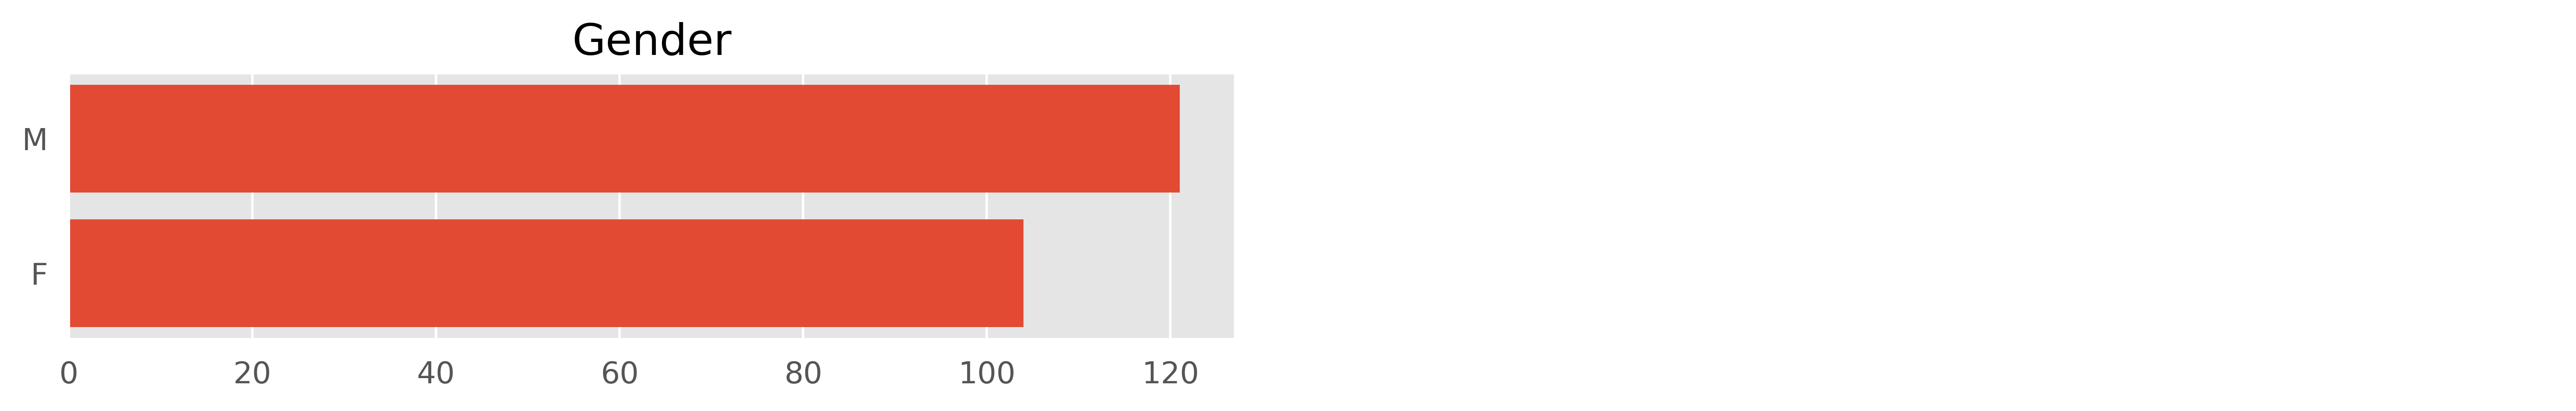

In [50]:
group_by_count_gender = users_log_eda \
    .select('userID', 'gender') \
    .dropDuplicates(['userId']) \
    .groupBy('gender') \
    .count() \
    .orderBy('count') \
    .toPandas()

x, y = limit_labels_and_characters(group_by_count_gender, 'gender')
Axes(x, y, 'Gender').plot(figsize=(12, 2))
plt.show();

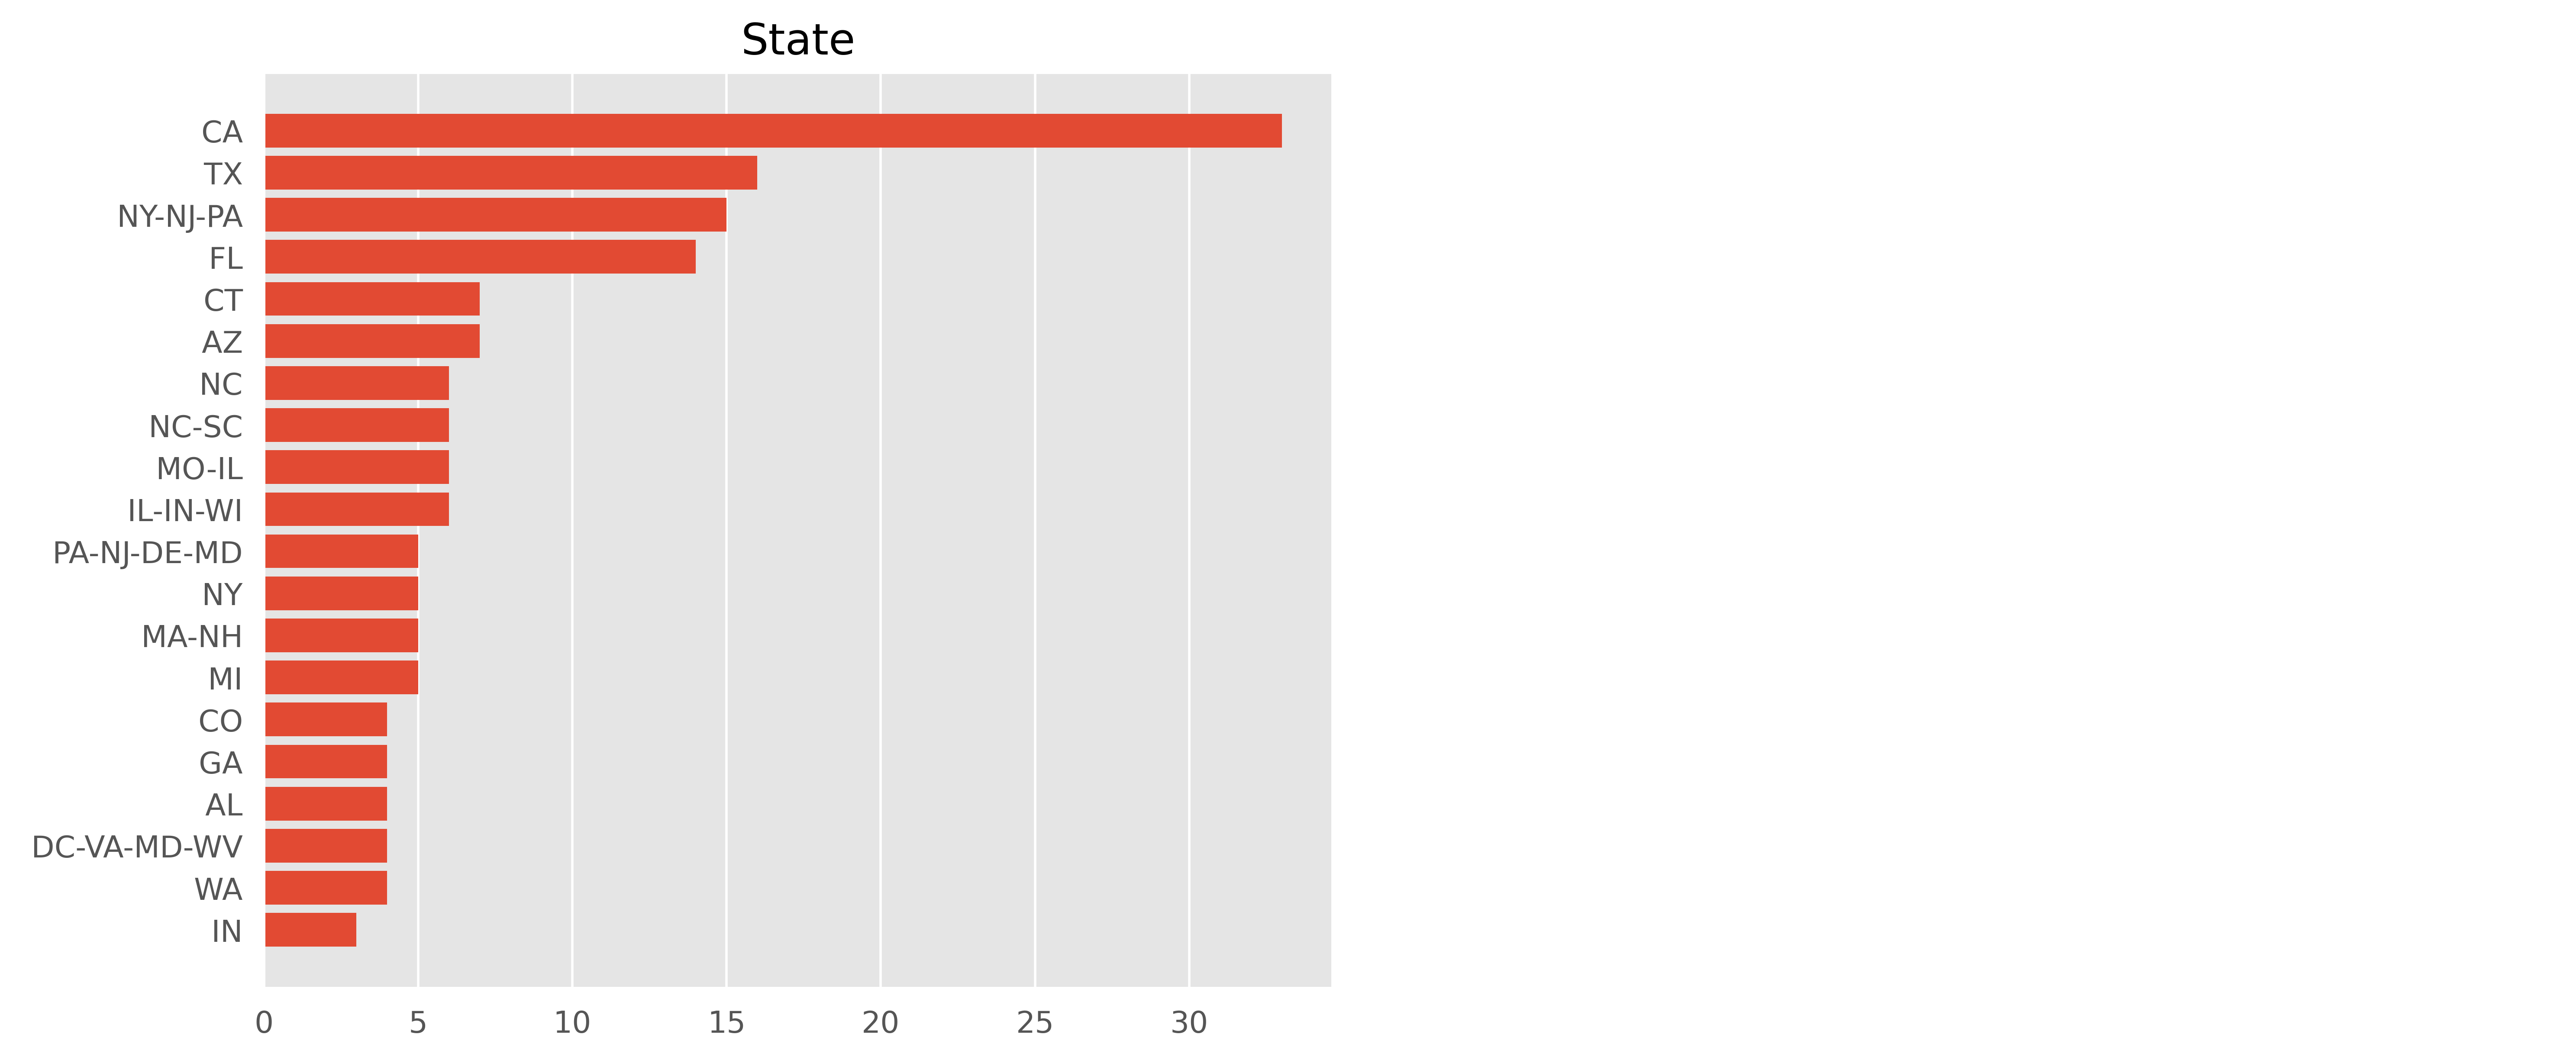

In [64]:
group_by_count_state = users_log_eda \
    .select('userID', 'state') \
    .dropDuplicates(['userId']) \
    .groupBy('state') \
    .count() \
    .orderBy('count') \
    .toPandas()

x, y = limit_labels_and_characters(group_by_count_state, 'state')
Axes(x, y, 'State').plot(figsize=(12, 5))
plt.show();

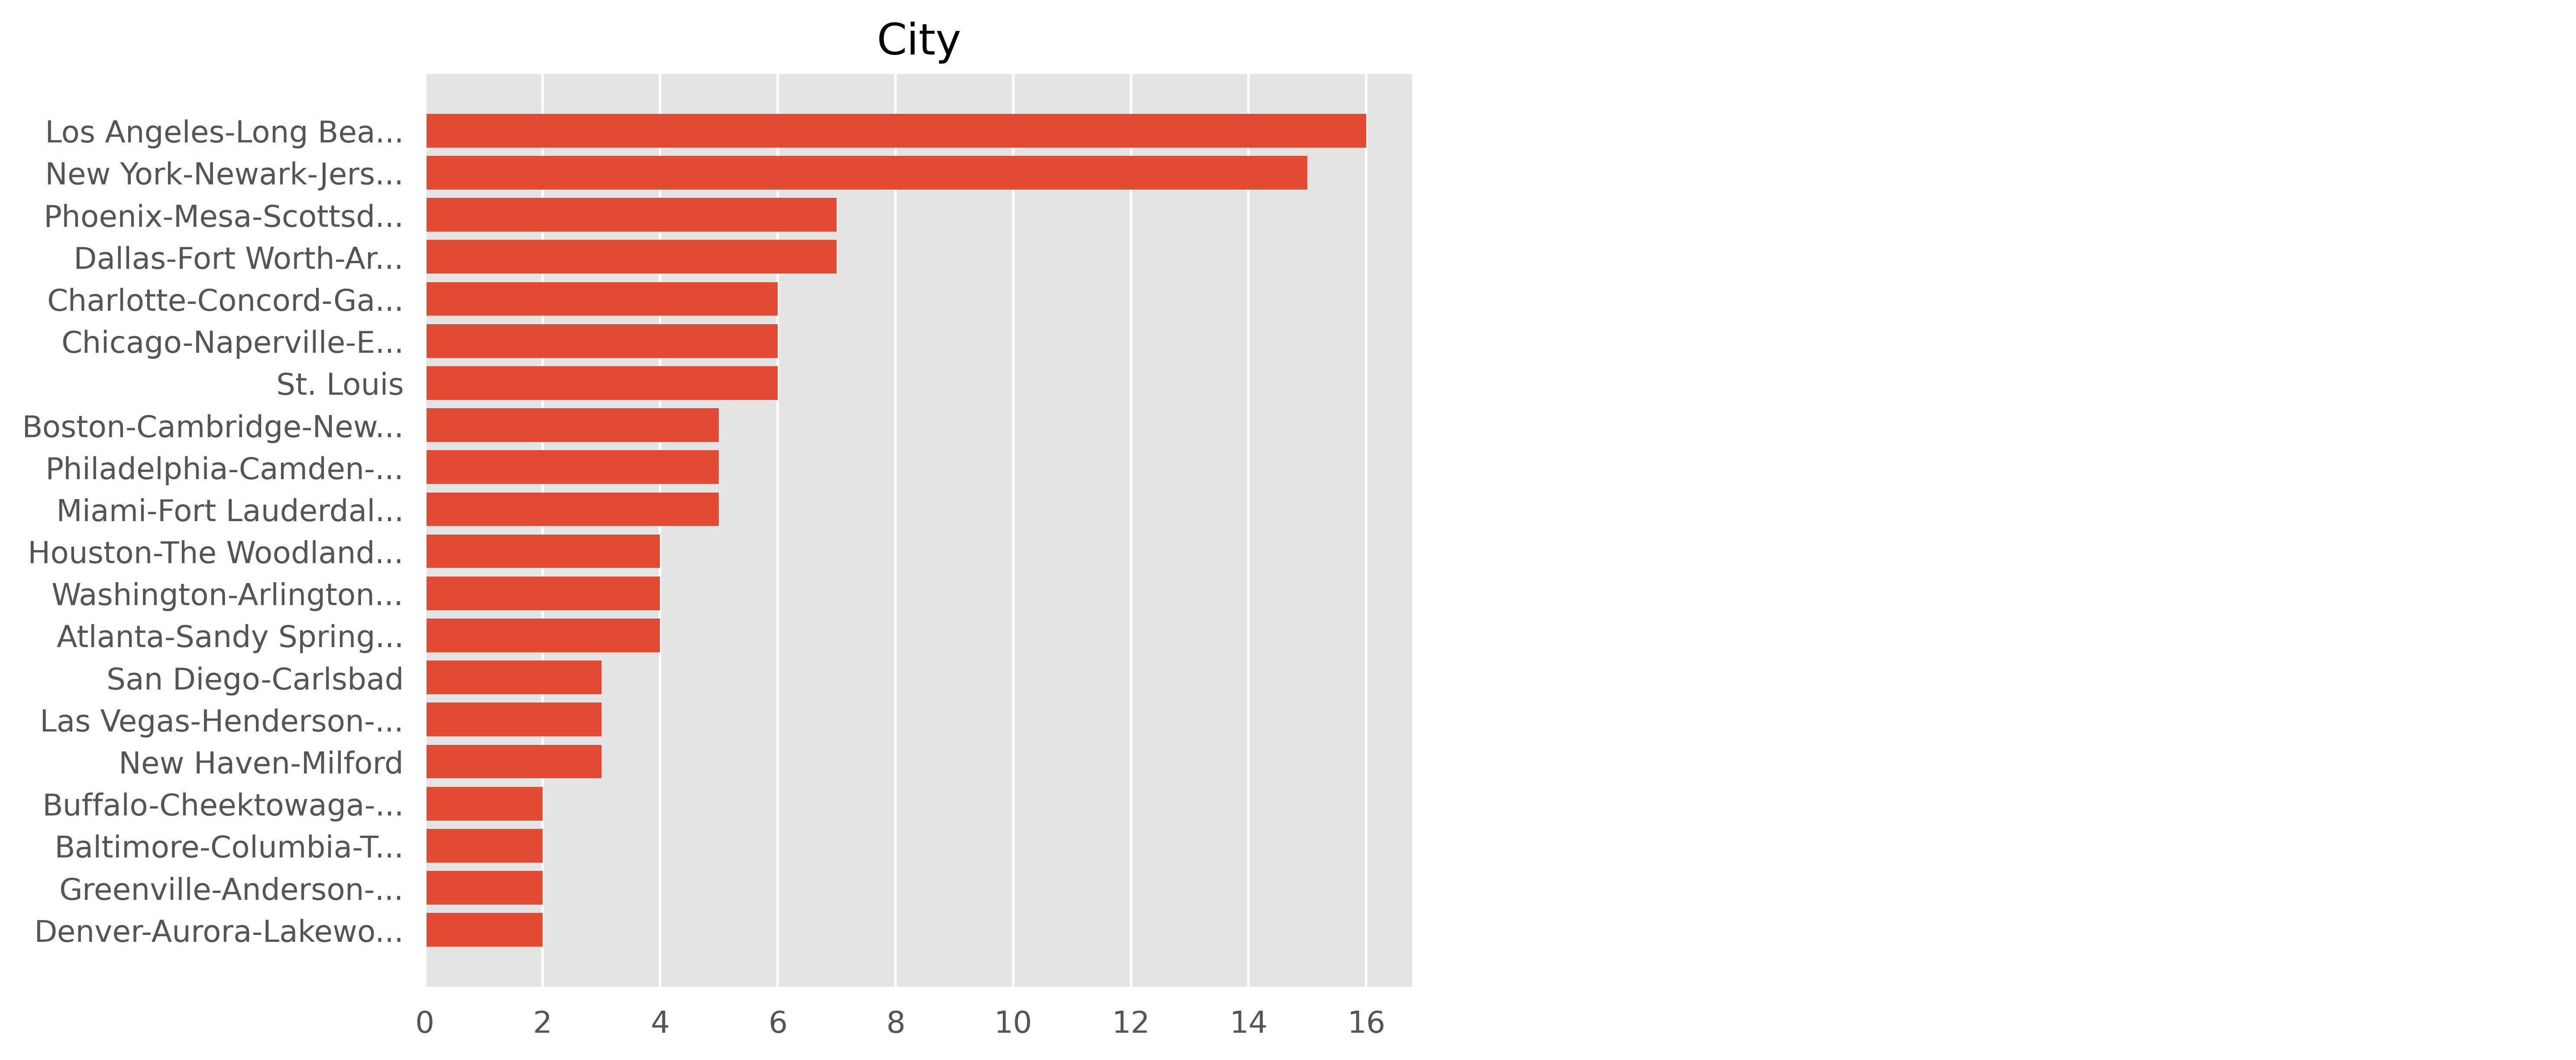

In [65]:
group_by_count_city = users_log_eda \
    .select('userID', 'city') \
    .dropDuplicates(['userId']) \
    .groupBy('city') \
    .count() \
    .orderBy('count') \
    .toPandas()

x, y = limit_labels_and_characters(group_by_count_city, 'city')
Axes(x, y, 'City').plot(figsize=(12, 5))
plt.show();

#### 2.2.1. Time related features

In [83]:
churned_users = users_log_eda \
    .select('userId', month('ts')) \
    .where('churn == 1') \
    .orderBy('userId') \
    .toPandas()

In [ ]:
# Colocar o start e end como variáveis da função de extrair os períodos

def create_date_table(start='2018-03-18', end='2018-12-02'):
    df = pd.DataFrame({'date': pd.date_range(start, end)})
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    return df

In [83]:
date_table = create_date_table()
date_table

,date,week,month
0,2018-03-18,11,3
1,2018-03-19,12,3
2,2018-03-20,12,3
3,2018-03-21,12,3
4,2018-03-22,12,3
...,...,...,...
255,2018-11-28,48,11
256,2018-11-29,48,11
257,2018-11-30,48,11
258,2018-12-01,48,12


In [ ]:
windowval = Window.partitionBy(['userId', 'page']).orderBy(desc('ts')).rowsBetween(Window.unboundedPreceding, currentRow())
# windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
# user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

## 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 5. Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [316]:
# Add downgrade

flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
users_log_eda = users_log_eda.withColumn('downgraded', flag_downgrade_event('page'))

In [317]:
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
users_log_eda = users_log_eda.withColumn('phase', Fsum('downgraded').over(windowval))

In [321]:
users_log_eda \
    .select('registration', 'ts', 'userId', 'churn', 'downgraded', 'phase', 'level', 'page', 'auth', 'method', 'status') \
    .where('''userId == 20
              and ts > "2018-10-03 01:34:00"
              and ts < "2018-10-08 08:25:00"
              --and page == "Submit Downgrade"''') \
    .orderBy('ts') \
    .limit(10) \
    .toPandas() \
    .head(10)

# 29, 100012, 54, 100017, 32

#     .where('userId == 29') \
#     .where('downgraded == 1') \

#     .where('''userId == 20
#               and ts > "2018-10-03 01:34:00"
#               and ts < "2018-10-08 08:25:00"''') \

#     .where('''userId == 38
#               and ts > "2018-10-02 18:30:00"
#               and ts < "2018-10-04 23:59:59"''') \

#     .where('''userId == 29
#               and ts > "2018-11-14 05:20:00"
#               and ts < "2018-11-15 23:59:59"''') \

,registration,ts,userId,churn,downgraded,phase,level,page,auth,method,status
0,2018-09-13 10:13:30,2018-10-03 01:34:51,20,0,0,2,paid,NextSong,Logged In,PUT,200
1,2018-09-13 10:13:30,2018-10-03 01:34:52,20,0,0,2,paid,Thumbs Up,Logged In,PUT,307
2,2018-09-13 10:13:30,2018-10-08 08:14:00,20,0,0,2,paid,NextSong,Logged In,PUT,200
3,2018-09-13 10:13:30,2018-10-08 08:15:55,20,0,0,2,paid,Downgrade,Logged In,GET,200
4,2018-09-13 10:13:30,2018-10-08 08:15:56,20,0,1,2,paid,Submit Downgrade,Logged In,PUT,307
5,2018-09-13 10:13:30,2018-10-08 08:15:58,20,0,0,1,free,Home,Logged In,GET,200
6,2018-09-13 10:13:30,2018-10-08 08:17:16,20,0,0,1,free,NextSong,Logged In,PUT,200
7,2018-09-13 10:13:30,2018-10-08 08:21:09,20,0,0,1,free,NextSong,Logged In,PUT,200


In [161]:
# Puxa a sequência de cores do estilo vigente

for i, color in enumerate(plt.rcParams['axes.prop_cycle']):
    print(color['color'])

#E24A33
#348ABD
#988ED5
#777777
#FBC15E
#8EBA42
#FFB5B8
